# Test Setup for Transient Analysis

In [35]:
from CircuitCalculator.Circuit.solution import DCSolution
from CircuitCalculator.Circuit.circuit import Circuit, transform_circuit
from CircuitCalculator.Circuit import components as cmp
from CircuitCalculator.Network import elements as elm
from CircuitCalculator.Network.network import Network, Branch

In [18]:
R1, R2, R3 = 10, 20, 30
RC = 40e6
C = 1e-3
circuit = Circuit([
    cmp.VoltageSource(id='Uq', V=1, nodes=('1', '0')),
    cmp.Resistor(id='R1', R=R1, nodes=('1', '2')),
    cmp.Resistor(id='R2', R=R2, nodes=('2', '0')),
    cmp.Resistor(id='R3', R=R3, nodes=('2', '3')),
    cmp.Capacitor(id='C', C=C, nodes=('3', '0')),
    cmp.Ground(nodes=('0',))
])
solution = DCSolution(circuit)

Network(branches=[Branch(node1='1', node2='0', element=NortenElement(name='Uq', type='voltage_source', Z=0, V=(1+0j))), Branch(node1='1', node2='2', element=NortenElement(name='R1', type='resistor', Z=10, V=0)), Branch(node1='2', node2='0', element=NortenElement(name='R2', type='resistor', Z=20, V=0)), Branch(node1='2', node2='3', element=NortenElement(name='R3', type='resistor', Z=30, V=0)), Branch(node1='3', node2='0', element=TheveninElement(name='C', type='admittance', Y=0j, I=0))], node_zero_label='0')

In [36]:
network = transform_circuit(circuit, w=0)
network = Network([
    Branch(node1='1', node2='0', element=elm.NortenElement(name='Uq', type='voltage_source', Z=0, V=1)),
    Branch(node1='1', node2='2', element=elm.NortenElement(name='R1', type='resistor', Z=R1, V=0)),
    Branch(node1='2', node2='0', element=elm.NortenElement(name='R2', type='resistor', Z=R2, V=0)),
    Branch(node1='2', node2='3', element=elm.NortenElement(name='R3', type='resistor', Z=R3, V=0)),
    Branch(node1='3', node2='0', element=elm.TheveninElement(name='C', type='capacitor', Y=1/RC, I=0))
])

In [19]:
from CircuitCalculator.Network.NodalAnalysis.node_analysis import *

Y = create_node_matrix_from_network(network)
Y = Y.real
print(Y)

[[ 0.18333333 -0.03333333]
 [-0.03333333  0.03333333]]


In [20]:
I = create_current_vector_from_network(network)
I = I.real
print(I)


[0.1 0. ]


Berechne State Space Matrizen per Hand

In [21]:
Z_ = np.matrix([[0, 1]])*np.linalg.inv(Y)
A = np.linalg.inv(Z_*np.matrix([[0], [-C]]))
B = -A*Z_*np.matrix([[1/R1], [0]])
print(A), print(B)

[[-27.27272727]]
[[18.18181818]]


(None, None)

## Berechnung der State Space Matrizen

In [52]:
node_index_mapper = map.default
network = transform_circuit(circuit, w=0)
node_mapping = node_index_mapper(network)
Y = create_node_matrix_from_network(network).real
I = create_current_vector_from_network(network).real
all_Cs = [c for c in circuit.components if c.type == 'capacitor']
P = np.zeros((len(all_Cs), Y.shape[1]))
for k in range(len(all_Cs)):
    for i_label, i in node_mapping.items():
        if i_label in all_Cs[k].nodes:
            P[k][i] = 1
print(P)

[[0. 1.]]


## Funktion zur Berechnung der State Space Matrizen

In [64]:
from CircuitCalculator.Network.NodalAnalysis import labelmapper as map
def create_state_space_matrices_from_circuit(circuit: Circuit, node_index_mapper: map.NodeIndexMapper = map.default) -> tuple[np.ndarray, np.ndarray]:
    network = transform_circuit(circuit, w=0)
    node_mapping = node_index_mapper(network)
    Y = create_node_matrix_from_network(network).real
    I = create_current_vector_from_network(network).real
    all_Cs = [c for c in circuit.components if c.type == 'capacitor']
    print(all_Cs)
    P = np.zeros((len(all_Cs), Y.shape[1]))
    for k in range(len(all_Cs)):
        for i_label, i in node_mapping.items():
            if i_label in all_Cs[k].nodes:
                P[k][i] = 1
    Z_ = np.matrix(P)*np.linalg.inv(Y)
    print(Z_)
    A = np.linalg.inv(Z_*np.matrix([[0], [-all_Cs[0].C]]))
    B = -A*Z_*np.matrix(I).T
    return A, B

In [65]:
A, B = create_state_space_matrices_from_circuit(circuit=circuit)
print(A), print(B)

[Capacitor(nodes=('3', '0'), type='capacitor', id='C', is_active=False, w=0, C=0.001)]
[[ 6.66666667 36.66666667]]
[[-27.27272727]]
[[18.18181818]]


(None, None)

In [25]:
from scipy import signal

sys = signal.StateSpace(A, B, 1, 0)


In [26]:
t = np.arange(0, 0.3, 0.0003)
U = t > 0.1

tout, yout, xout = signal.lsim(sys, U, t)

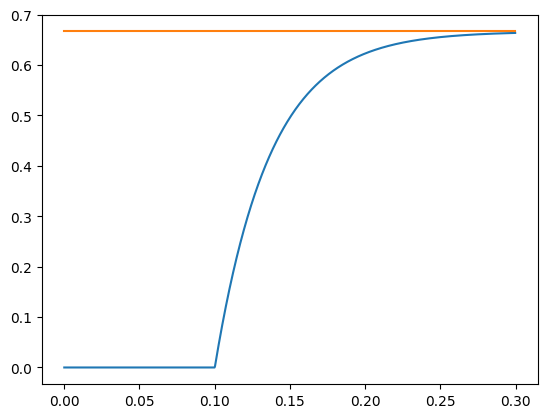

In [27]:
import matplotlib.pyplot as plt

plt.plot(tout, yout)
plt.plot((tout[0], tout[-1]), (solution.get_voltage('C'), solution.get_voltage('C')))